# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2020

Мягкий дедлайн: 23:59MSK 10.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [33]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


ss = StandardScaler()
scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [34]:
print('Class balance: ', y.mean())

Class balance:  0.4995


In [35]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters = {'C': np.logspace(0.1, 2, 10)}

svc = LinearSVC()
gsearch = GridSearchCV(svc, parameters, cv=5, verbose=1, scoring='average_precision')
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': array([  1.25892541,   2.04696827,   3.32829814,   5.41169527,
         8.79922544,  14.30722989,  23.26305067,  37.82489906,
        61.50195043, 100.        ])},
             scoring='average_precision', verbose=1)

In [36]:
best_C_SVC = gsearch.best_params_['C']
print('Best train AUC-PR score: %.5f' % gsearch.best_score_)
print('Best C: %.5f' % best_C_SVC)

Best train AUC-PR score: 0.82352
Best C: 5.41170


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

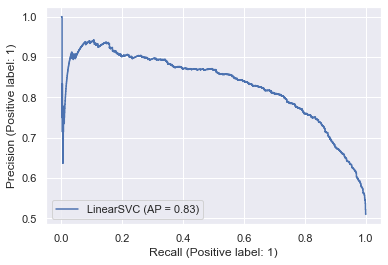

In [37]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

svc = LinearSVC(C=best_C_SVC)
svc.fit(X_train, y_train)

pr_display = PrecisionRecallDisplay.from_estimator(svc, X_test, y_test)

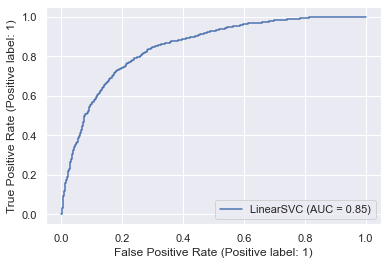

In [38]:
roc_display = RocCurveDisplay.from_estimator(svc, X_test, y_test)

In [39]:
y_pred = svc.decision_function(X_test)
print('SVC test ROC-AUC: %.5f' % roc_auc_score(y_test, y_pred))

SVC test ROC-AUC: 0.84770


In [40]:
y_pred = svc.decision_function(X_test)
print('SVC test AUC-PR: %.5f' % average_precision_score(y_test, y_pred))

SVC test AUC-PR: 0.82975


А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
parameters = {'C': np.logspace(0.1, 2, 10)}

lr = LogisticRegression()
gsearch = GridSearchCV(lr, parameters, cv=5, verbose=1, scoring='average_precision')
gsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([  1.25892541,   2.04696827,   3.32829814,   5.41169527,
         8.79922544,  14.30722989,  23.26305067,  37.82489906,
        61.50195043, 100.        ])},
             scoring='average_precision', verbose=1)

In [43]:
best_C_logistic = gsearch.best_params_['C']

lr = LogisticRegression(C=best_C_logistic, )
lr.fit(X_train, y_train)

print('Best train AUC-PR score: %.5f' % gsearch.best_score_)
print('Best C: %.5f' % best_C_logistic)


Best train AUC-PR score: 0.82248
Best C: 1.25893


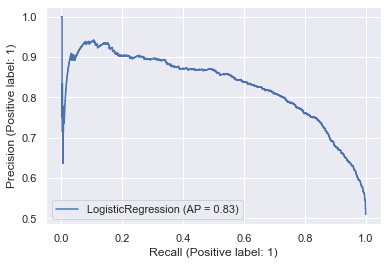

In [44]:
pr_display = PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)

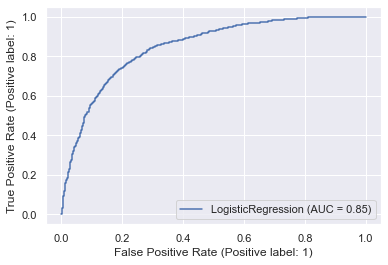

In [45]:
roc_display = RocCurveDisplay.from_estimator(lr, X_test, y_test)

In [46]:
y_pred = lr.decision_function(X_test)
print('test ROC-AUC: %.5f' % roc_auc_score(y_test, y_pred))

test ROC-AUC: 0.84787


In [47]:
y_pred = lr.decision_function(X_test)
print('test ROC-PR: %.5f' % average_precision_score(y_test, y_pred))

test ROC-PR: 0.82938


В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [48]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=30)

ss = StandardScaler()
scaler = StandardScaler().fit(X, y)
X = scaler.transform(X)

In [49]:
svc = SVC(C=best_C_SVC, kernel='linear', probability=True)
svc.fit(X, y)
y_pred = svc.predict_proba(X)

support_vectors = svc.support_vectors_

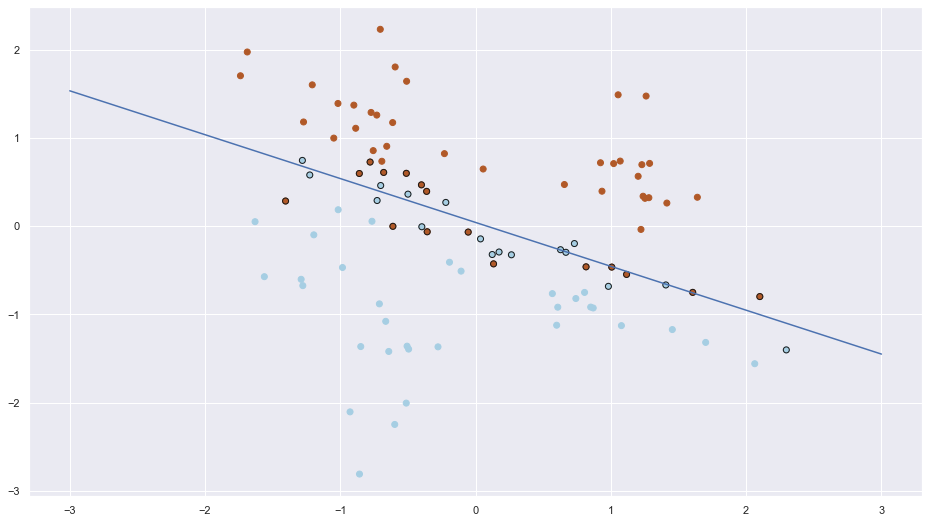

In [50]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('SVS hyperplane')
plt.xlabel('x')
plt.xlabel('y')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors="none", edgecolors="k")

## from sklearn docs
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx - (svc.intercept_[0]) / w[1]
plt.plot(xx, yy)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [51]:
## from sklearn docs

lr.fit(X, y)

b = lr.intercept_[0]
w1, w2 = lr.coef_.T

c = -b/w2
m = -w1/w2

xd = np.array([-3, 3])
yd = m * xd + c

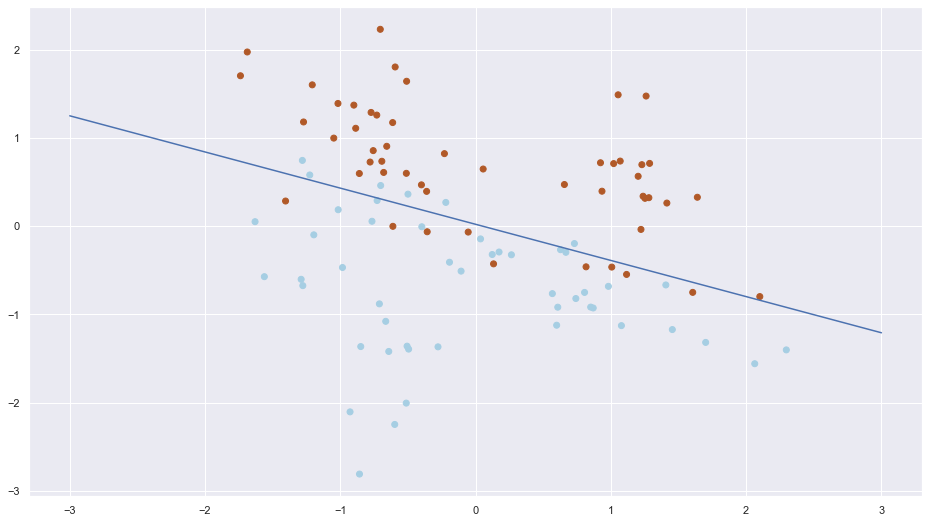

In [52]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('LR hyperplane')
plt.xlabel('x')
plt.xlabel('y')
plt.plot(xd, yd, 'b')

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [53]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6, 6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [54]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


ss = StandardScaler()
scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

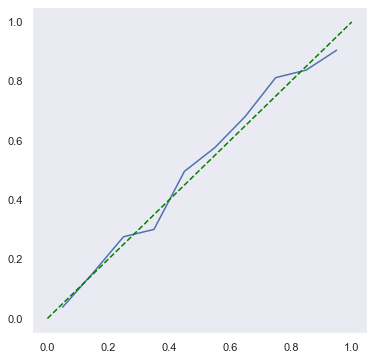

In [55]:
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)

plt.grid()
plt.title('SVC calibration curve')
plt.xlabel('x')
plt.xlabel('y')
plot_calibration_curve(y_test, lr_pred[:, 1])
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
# sns.set(style="lightgrid")

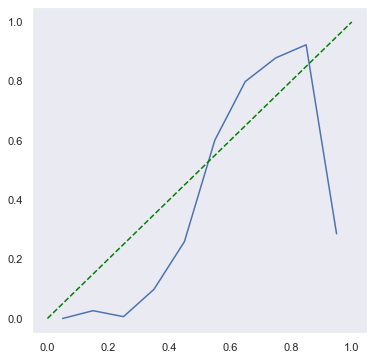

In [56]:
svc.fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

plt.grid()
plt.title('LR calibration curve')
plt.xlabel('x')
plt.xlabel('y')
plot_calibration_curve(y_test, svc_pred)
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
# sns.set(style="lightgrid")

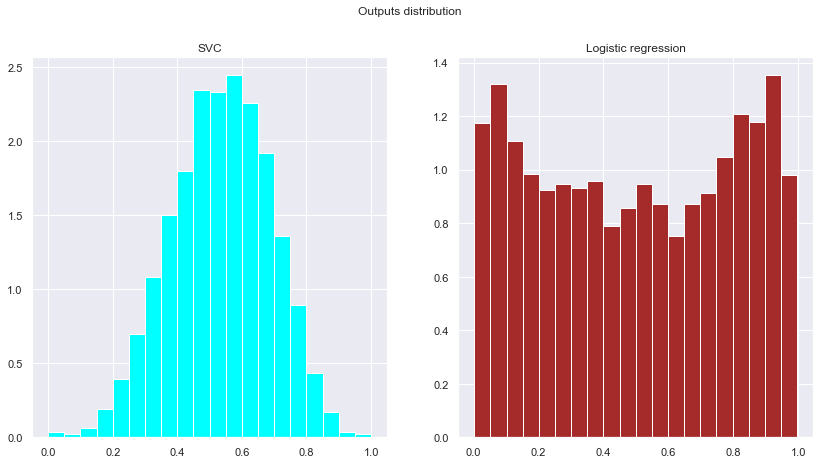

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='cyan', density='True')
axs[1].hist(lr_pred[:, 1], bins=20, color='brown', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution', size=20)
plt.show()

   *Добрый вечер, пишу вам из далекого Сибирского города Шайтата. Как у вас дела? Не болеете ли? Как там поживает тетя Нина,
как ее огурчики, все так же, в теплице? Почему от вас не было вестей, мы уж начали беспокоиться.
   Пишу я вам по делу. После долгих размышлений я так и не смог сделать вывод исходя из графиков, которые я вам прикладываю в письме, возможно ваш острый глаз и не менее острый ум смогут встать в один строй и выдать корректный ответ. Поэтому жду с нетерпением весточки, как только получите мое письмо.*
   
   
*С любовью, __Ерогов Налим__*.

**Ответ:** В первом случае выдается неотнормированные вероятности у svc, во втором с помощью predict_proba все четко уже.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [58]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]

print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.847879127585721


In [59]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.8475768665397467


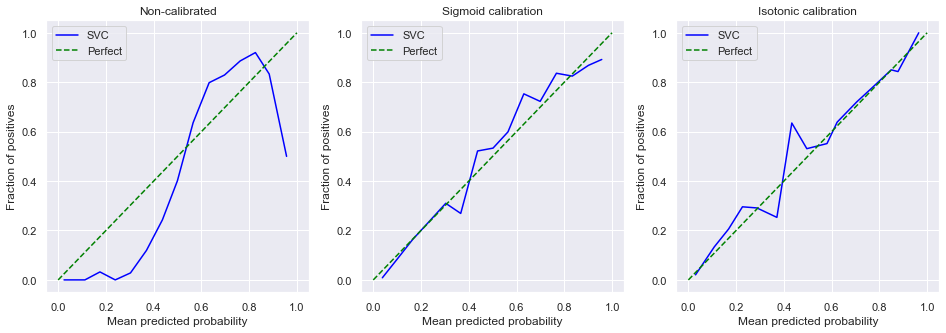

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()


**Вывод:** Да, улучшилась, помогла калибровочка

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [61]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

--2021-11-10 17:06:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 444572 (434K) [application/x-httpd-php]
Сохранение в: «bank-additional.zip.3»

bank-additional.zip 100%[===================>] 434,15K   453KB/s    за 1,0s    

2021-11-10 17:06:22 (453 KB/s) - «bank-additional.zip.3» сохранён [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [62]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [63]:
df.drop(['duration'], axis=1, inplace=True) ## unknown before call

df.loc[df['y'] == 'no', 'y'] = 0
df.loc[df['y'] == 'yes', 'y'] = 1
df['y'] = df['y'].astype(int)

print('Class balance: ', df['y'].mean())

Class balance:  0.11265417111780131


In [64]:
train, test = train_test_split(df, train_size=0.75, random_state=777, stratify=df['y'])

X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

y_train = train['y']
y_test = test['y']

In [65]:
print('Train class balance: ', y_train.mean())
print('Test class balance: ', y_test.mean())

Train class balance:  0.11265417111780131
Test class balance:  0.11265417111780131


Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Из-за баланса классов

In [66]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [67]:
categorical = X_train.select_dtypes('object').columns
numeric = X_test.select_dtypes(np.number).columns

In [68]:
%%time

column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ordinal_and_scaling', column_transformer),
    ('logreg', LogisticRegression())
])


lr = pipeline.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:, 1]

print('AUC-PR: %.4f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4423
CPU times: user 822 ms, sys: 70.7 ms, total: 892 ms
Wall time: 596 ms


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [69]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logreg', LogisticRegression())
])


lr = pipeline.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:, 1]
print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4495
CPU times: user 1.26 s, sys: 116 ms, total: 1.37 s
Wall time: 1.05 s


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [70]:
def counters(train, test, categorical):
    df_train = train.copy()
    df_test = test.copy()
    for column in categorical:
        for cat in df_train[column].unique():
            mean_val = df_train[df_train[column] == cat]['y'].mean()
            df_train.loc[df_train[column] == cat, column] = mean_val
            df_test.loc[df_test[column] == cat, column] = mean_val
    return df_train, df_test

In [71]:
%%time

X_train_counters, X_test_counters = counters(train, test, categorical)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])


lr = pipeline.fit(X_train_counters, y_train)
y_pred = lr.predict_proba(X_test_counters)[:, 1]

print('AUC-PR: %.4f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4240
CPU times: user 677 ms, sys: 47.6 ms, total: 725 ms
Wall time: 789 ms


In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

class CounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.counted = {}
    
    def init(self):
        super().__init__()
        
    def fit(self, train): 
        for feature in self.categorical:
            self.counted[feature] = train.groupby(feature).mean()[['y']]
            
        return self
        
    def transform(self, df):       
        data = df.copy()
        for feature in self.categorical:
            data = data.join(self.counted[feature], on=feature, rsuffix='_%s' % feature)
            data[feature] = data['y_%s' % feature]
            data.drop('y_%s' % feature, axis=1, inplace=True)
            
        return data

In [73]:
transformer = CounterTransformer(categorical).fit(train)
train_transformed = transformer.transform(train)
test_transformed = transformer.transform(test)

In [74]:
%%time

X_train = train_transformed.drop(['y'], axis=1)
X_test = test_transformed.drop(['y'], axis=1)

y_train = train_transformed['y']
y_test = test_transformed['y']

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])


lr = pipeline.fit(X_train, y_train)
y_pred = lr.predict_proba(X_test)[:, 1]

print('AUC-PR: %.4f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4425
CPU times: user 641 ms, sys: 63.6 ms, total: 704 ms
Wall time: 465 ms


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [75]:
import random

class NoiseCounterTransformer(CounterTransformer):
    def init(self):
        super().__init__()
             
        
    def transform(self, df, eps):    
        data = df.copy()
        for feature in self.categorical:
            data = data.join(self.counted[feature], on=feature, rsuffix='_%s' % feature)
            std = data['y_%s' % feature].std()
            data[feature] = (data['y_%s' % feature] + [random.uniform(-std, +std) / eps for _ in range(data.shape[0])])
            data.drop('y_%s' % feature, axis=1, inplace=True)
            
        return data
            
        
        

In [76]:
%%time

eps = 10
transformer = NoiseCounterTransformer(categorical).fit(train)
train_transformed = transformer.transform(train, eps)
test_transformed = transformer.transform(test, eps)

X_train = train_transformed.drop(['y'], axis=1)
X_test = test_transformed.drop(['y'], axis=1)

y_train = train_transformed['y']
y_test = test_transformed['y']


column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

print('AUC-PR: %.10f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4428545071
CPU times: user 1.27 s, sys: 171 ms, total: 1.44 s
Wall time: 1.52 s


**Ответ:** Шум не сильно меняет качество

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [84]:
class FoldNoiseCounterTransformer(NoiseCounterTransformer):
    def __init__(self, categorical, kfolds):
        self.kfolds = kfolds
        self.categorical = categorical
        self.counted = {}
    
    def init(self):
        super().__init__()
        
    def fit(self, df): 
        space = np.linspace(0, len(df), self.kfolds + 1)
        self.space = space
        for feature in self.categorical:
            self.counted[feature] = []
            for i in range(self.kfolds):
                if i == 0:
                    left = int(space[i])
                    right = int(space[i + 1])
                else:
                    left = right
                    right = int(space[i + 1])
                    if i == self.kfolds:
                        right += 1

                subset = df.drop(df.iloc[left:right].index)
                self.counted[feature].append(subset.groupby(feature).mean()[['y']])
                
            self.counted[feature + '_test'] = df.groupby(feature).mean()[['y']]
        
        return self
    
    def transform(self, df, eps, is_train):
        data = df.copy()
        if is_train:
            for feature in self.categorical:
                for i in range(self.kfolds):
                    if i == 0:
                        left = int(self.space[i])
                        right = int(self.space[i + 1])
                    else:
                        left = right
                        right = int(self.space[i + 1])
                        if i == self.kfolds:
                            right += 1

                    tmp = data.iloc[left:right].join(self.counted[feature][i], on=feature, rsuffix='_%s' % feature)
                    data.iloc[left:right, data.columns.get_loc(feature)] = tmp['y_%s' % feature]
        else:
            for feature in self.categorical:
                feature = feature
                data = data.join(self.counted[feature + '_test'], on=feature, rsuffix='_%s' % feature)
                std = data['y_%s' % feature].std()
                data[feature] = (data['y_%s' % feature])
                data.drop('y_%s' % feature, axis=1, inplace=True)


            
        return data
    
    

In [85]:
%%time

eps = 1
transformer = FoldNoiseCounterTransformer(categorical, 5)
transformer.fit(train)
train_transformed = transformer.transform(train, eps, True)
test_transformed = transformer.transform(test, eps, False)

X_train = train_transformed.drop(['y'], axis=1)
X_test = test_transformed.drop(['y'], axis=1)

y_train = train_transformed['y']
y_test = test_transformed['y']



column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

print('AUC-PR: %.10f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4434023839
CPU times: user 1.96 s, sys: 164 ms, total: 2.13 s
Wall time: 2.11 s


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [87]:
class SmoothCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical, C):
        self.categorical = categorical
        self.counted = {}
        self.C = C
    
    def init(self):
        super().__init__()
        
    def fit(self, train): 
        for feature in self.categorical:
            self.counted[feature] = train.groupby(feature).sum()[['y']] + self.C * train['y'].mean() / train.groupby(feature).count()[['y']] + self.C
            
        return self
        
    def transform(self, df):       
        data = df.copy()
        for feature in self.categorical:
            data = data.join(self.counted[feature], on=feature, rsuffix='_%s' % feature)
            data[feature] = data['y_%s' % feature]
            data.drop('y_%s' % feature, axis=1, inplace=True)
            
        return data

In [121]:
%%time

eps = 1
transformer = SmoothCounterTransformer(categorical, 10)
transformer.fit(train)
train_transformed = transformer.transform(train)
test_transformed = transformer.transform(test)

X_train = train_transformed.drop(['y'], axis=1)
X_test = test_transformed.drop(['y'], axis=1)

y_train = train_transformed['y']
y_test = test_transformed['y']



column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

print('AUC-PR: %.10f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4238604667
CPU times: user 1.45 s, sys: 168 ms, total: 1.61 s
Wall time: 1.41 s


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [88]:
categorical = np.append(categorical, 'age')
numeric = np.delete(numeric, np.where(numeric == 'age'))


eps = 0.1
transformer = NoiseCounterTransformer(categorical)
transformer.fit(train)
train_transformed = transformer.transform(train, eps)
test_transformed = transformer.transform(test, eps)
test_transformed.drop(test_transformed[test_transformed['age'].isna() == True].index, inplace=True)

X_train = train_transformed.drop(['y'], axis=1)
X_test = test_transformed.drop(['y'], axis=1)


y_train = train_transformed['y']
y_test = test_transformed['y']


column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])

# lr = LogisticRegression()
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

print('AUC-PR: %.10f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4242556104


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [89]:
numeric = np.append(numeric, ['day_of_week', 'months'])
categorical = np.delete(categorical, np.where((categorical == 'day_of_week') | (categorical == 'month')))


In [90]:
day_of_week = {}
for i, name in enumerate(df['day_of_week'].unique()):
    day_of_week[name] = i

months = {}
for i, name in enumerate(df['month'].unique()):
    months[name] = i
    
train['day_of_week'] = train['day_of_week'].apply(lambda x: day_of_week[x])
train['month'] = train['month'].apply(lambda x: months[x])
test['day_of_week'] = test['day_of_week'].apply(lambda x: day_of_week[x])
test['month'] = test['month'].apply(lambda x: months[x])



eps = 0.1
transformer = NoiseCounterTransformer(categorical)
transformer.fit(train)
train_transformed = transformer.transform(train, eps)
test_transformed = transformer.transform(test, eps)
test_transformed.drop(test_transformed[test_transformed['age'].isna() == True].index, inplace=True)

X_train = train_transformed.drop(['y'], axis=1)
X_test = test_transformed.drop(['y'], axis=1)


y_train = train_transformed['y']
y_test = test_transformed['y']


column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), X_train.columns)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logreg', LogisticRegression())
])

# lr = LogisticRegression()
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict_proba(X_test)[:, 1]

print('AUC-PR: %.10f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.4298979119


**Ответ:** Не-а

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 1. Не увеличивают число признаков 2. Напрямую связаны с таргетом

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [91]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [92]:
categorical = X_train.select_dtypes('object').columns
numeric = X_train.select_dtypes(np.number).columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.fit_transform(X_train).shape)


Size before OneHot: (32950, 19)
Size after OneHot: (32950, 62)


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [93]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)

ss = StandardScaler().fit(X_train_ohe[numeric])
X_train_ohe[numeric] = ss.transform(X_train_ohe[numeric])
X_test_ohe[numeric] = ss.transform(X_test_ohe[numeric])

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4477


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [96]:
%%time
feature_imp = pd.DataFrame({'feature': X_train_ohe.columns, 'importance': abs(lr.coef_[0])})
cols2keep = feature_imp.sort_values('importance', ascending=False).head(40)['feature']

CPU times: user 3.84 ms, sys: 9.99 ms, total: 13.8 ms
Wall time: 14.9 ms


In [97]:
X_train_ohe = X_train_ohe[cols2keep]
X_test_ohe = X_test_ohe[cols2keep]

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4486


**Вывод:** Качество улучшилось

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [98]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4303


In [99]:
feature_imp = pd.DataFrame({'feature': X_train_ohe.columns, 'importance': abs(lr.coef_[0])})
cols2keep = feature_imp.sort_values('importance', ascending=False).head(40)['feature']

In [100]:
X_train_ohe = X_train_ohe[cols2keep]
X_test_ohe = X_test_ohe[cols2keep]

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4394


**Вывод:** Качество улучшилось

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [101]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)

ss = StandardScaler().fit(X_train_ohe)
X_train_ohe = ss.transform(X_train_ohe)
X_test_ohe = ss.transform(X_test_ohe)

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4478


**Ответ:** Да, изменился, качество заметно улучшилось

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [102]:
%%time

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)

cols = X_train_ohe.columns


num = abs(X_train_ohe[y_train == 1].mean() - X_train_ohe[y_train == 0].mean())
den = np.sqrt(y_train.value_counts()[True] * X_train_ohe[y_train == 1].var() + 
              y_train.value_counts()[False] * X_train_ohe[y_train == 0].var()
             ) / np.sqrt(y_train.value_counts()[True] + y_train.value_counts()[False])

feature_imp = pd.DataFrame({'feature': cols, 'importance': num / den})
cols2keep = feature_imp.sort_values('importance', ascending=False).head(40)['feature']

CPU times: user 320 ms, sys: 77.8 ms, total: 398 ms
Wall time: 417 ms


In [103]:
X_train_ohe = X_train_ohe[cols2keep]
X_test_ohe = X_test_ohe[cols2keep]

ss = StandardScaler().fit(X_train_ohe)
X_train_ohe = ss.transform(X_train_ohe)
X_test_ohe = ss.transform(X_test_ohe)

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]

print("AUC-PR = %.4f" % average_precision_score(y_test, y_pred))

AUC-PR = 0.4517


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [104]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)
X_train_ohe, X_val_ohe, y_train, y_val = train_test_split(X_train_ohe, y_train, test_size=0.2, random_state=777, stratify=y_train)

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_val_ohe)[:, 1]


base_score = average_precision_score(y_val, y_pred)
print('%.4f' % base_score)

0.4233


In [105]:
%%time

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)
X_train_ohe, X_val_ohe, y_train, y_val = train_test_split(X_train_ohe, y_train, test_size=0.2, random_state=777, stratify=y_train)

col2del = ''
features = X_train_ohe.columns
for i in range(len(features) - 40):
    worst_exist = 0
    for feature in features:
        tmp_features = np.delete(features, np.where(features == feature))
        
        X_train_check = X_train_ohe[tmp_features]
        X_val_check = X_val_ohe[tmp_features]

        ss = StandardScaler().fit(X_train_check)
        X_train_check = ss.transform(X_train_check)
        X_val_check = ss.transform(X_val_check)

        lr = LogisticRegression()
        lr.fit(X_train_check, y_train)
        y_pred = lr.predict_proba(X_val_check)[:, 1]
        score = average_precision_score(y_val, y_pred)
        if score >= base_score:
            base_score = score
            col2del = feature
            worst_exist = 1

    if worst_exist != 1:
        break
    else:
        features = np.delete(features, np.where(features == col2del))



CPU times: user 8min 10s, sys: 51.6 s, total: 9min 2s
Wall time: 5min 38s


In [106]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)
X_train_ohe = X_train_ohe[features]
X_test_ohe = X_test_ohe[features]


ss = StandardScaler().fit(X_train_ohe)
X_train_ohe = ss.transform(X_train_ohe)
X_test_ohe = ss.transform(X_test_ohe)

lr = LogisticRegression()
lr.fit(X_train_ohe, y_train)
y_pred = lr.predict_proba(X_test_ohe)[:, 1]
score = average_precision_score(y_test, y_pred)
print('%.4f' % score)

0.4488


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [107]:
##WTF

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_ohe = pd.get_dummies(X, columns=categorical)
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=777, stratify=y)
X_train_ohe, X_val_ohe, y_train, y_val = train_test_split(X_train_ohe, y_train, test_size=0.2, random_state=777, stratify=y_train)

col2del = ''
features = []

for i in range(40):        
    X_train_check = X_train_ohe[tmp_features]
    X_val_check = X_val_ohe[tmp_features]

    ss = StandardScaler().fit(X_train_check)
    X_train_check = ss.transform(X_train_check)
    X_val_check = ss.transform(X_val_check)

    lr = LogisticRegression()
    lr.fit(X_train_check, y_train)
    y_pred = lr.predict_proba(X_val_check)[:, 1]
    score = average_precision_score(y_val, y_pred)
    
    

feature_imp = pd.DataFrame({'feature': cols, 'importance': num / den})
cols2keep = feature_imp.sort_values('importance', ascending=False).head(40)['feature']

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Лучшим по качеству отбором является использование t-статистики, также выполняется быстро. Методы с перебором признаков более основательны, но занимают больше времени.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [108]:
from sklearn.model_selection import KFold

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

categorical = X.select_dtypes('object').columns
numeric = X.select_dtypes(np.number).columns

kf = KFold(n_splits=5, shuffle=True, random_state=500)

earnings = np.array([])
total_calls = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipeline = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    earnings = np.append(earnings, (y_pred * y_test).sum() * 10)
    total_calls += y_pred.sum()

In [109]:
print('Mean earnings: %.1f' %  earnings.mean())
print('Std earnings: %.1f' % earnings.std())
print('Total calls: %.1f' % (total_calls / 5))
print('Mean profit: %.1f' % (earnings.mean() - total_calls / 5))

Mean earnings: 2130.0
Std earnings: 104.9
Total calls: 323.8
Mean profit: 1806.2


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [110]:
kf = KFold(n_splits=5, shuffle=True, random_state=500)

earnings = np.array([])
total_calls = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipeline = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    random_earning = np.random.uniform(0, 20)
    
    earnings = np.append(earnings, (y_pred * y_test).sum() * random_earning)
    total_calls += y_pred.sum()

In [111]:
print('Mean earnings: %.1f' %  earnings.mean())
print('Std earnings: %.1f' % earnings.std())
print('Total calls: %.1f' % (total_calls / 5))
print('Mean profit: %.1f' % (earnings.mean() - total_calls / 5))

Mean earnings: 2226.9
Std earnings: 911.6
Total calls: 323.8
Mean profit: 1903.1


**Ответ:** Очень большая дисперсия, разные значения при каждом запуске.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [112]:
from tqdm import tqdm

kf = KFold(n_splits=5, shuffle=True, random_state=500)



best_c = None
best_profit = 0

mean_profits = []
std_profits = []

for c in tqdm(np.logspace(-1, 2, 10)):
    profits = np.array([])
    earnings = np.array([])
    total_calls = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]



        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('scaling', StandardScaler(), numeric)
        ])

        pipeline = Pipeline(steps=[
            ('scaling', column_transformer),
            ('logreg', LogisticRegression(C=c))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        random_earning = np.random.uniform(0, 20)

        earnings = np.append(earnings, (y_pred * y_test).sum() * random_earning)
        total_calls = y_pred.sum()
        profits = np.append(profits, (y_pred * y_test).sum() * random_earning - total_calls)
        
    mean_profit = profits.mean()
    
    mean_profits.append(mean_profit)
    std_profits.append(profits.std())
    
    if mean_profit > best_profit:
        best_c = c
        best_profit = mean_profit
    

100%|██████████| 10/10 [00:49<00:00,  5.00s/it]


In [113]:
print('Best C: ', best_c)
print('Best mean profit: %.1f' % best_profit)

Best C:  0.1
Best mean profit: 2885.5


<ErrorbarContainer object of 3 artists>

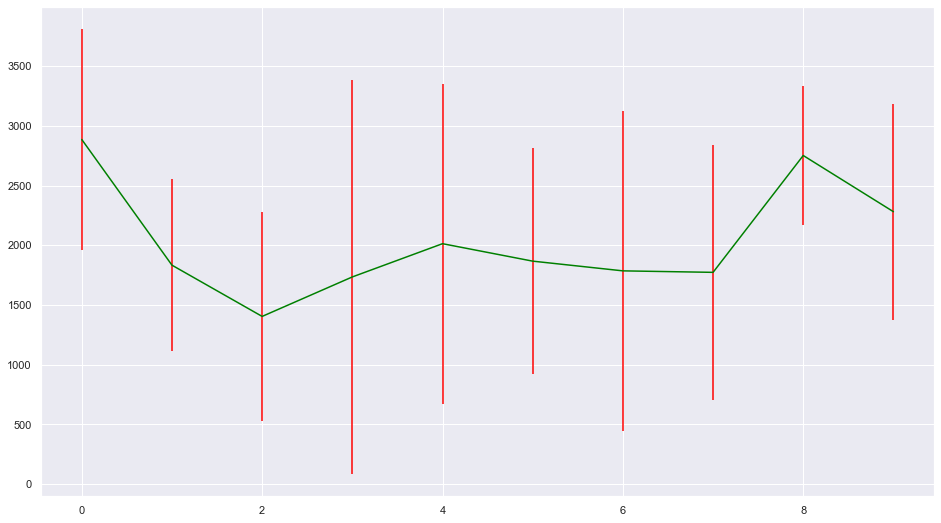

In [114]:
plt.title('Coef dependence')
plt.xlabel('C')
plt.xlabel('mean_profits')
plt.figure(figsize=(16, 9))
plt.errorbar([i for i in range(len(mean_profits))], mean_profits, yerr=std_profits, c='green', ecolor='red')

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

**Ответ:** Все зависит от рандомного выбора значения оалаты клиента.

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Для данной задачи важнее recall, так как звонок стоит всего лишь 1$, тогда как за верный звонок мы получим в 10 раз больше выручки.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [115]:
from tqdm import tqdm

kf = KFold(n_splits=5, shuffle=True, random_state=500)



best_c = None
best_profit = 0
best_threshold = 0

mean_profits = []
std_profits = []

for threshold in tqdm(np.linspace(0, 1, 100)):
    profits = np.array([])
    earnings = np.array([])
    total_calls = 0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]



        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('scaling', StandardScaler(), numeric)
        ])

        pipeline = Pipeline(steps=[
            ('scaling', column_transformer),
            ('logreg', LogisticRegression(C=c))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)[:, 1]
        y_pred = y_pred > threshold

        random_earning = np.random.uniform(0, 20)

        earnings = np.append(earnings, (y_pred * y_test).sum() * random_earning)
        total_calls = y_pred.sum()
        profits = np.append(profits, (y_pred * y_test).sum() * random_earning - total_calls)
        
    mean_profit = profits.mean()
    
    mean_profits.append(mean_profit)
    std_profits.append(profits.std())
    
    if mean_profit > best_profit:
        best_c = c
        best_profit = mean_profit
        best_threshold = threshold
    

100%|██████████| 100/100 [09:09<00:00,  5.49s/it]


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [116]:
print('Best threshold: ', best_threshold)
print('Best mean profit: %.1f' % best_profit)

Best threshold:  0.20202020202020204
Best mean profit: 6917.8


<ErrorbarContainer object of 3 artists>

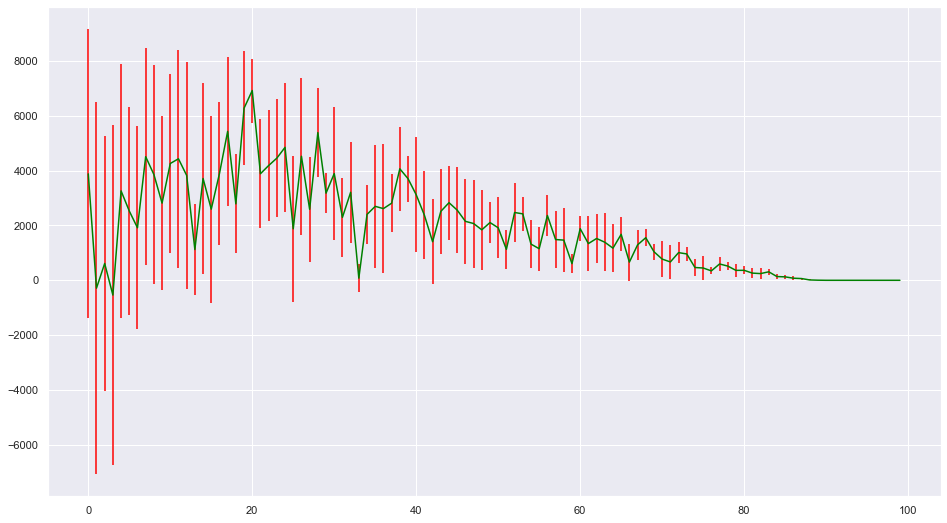

In [117]:
plt.title('Threshold dependence')
plt.xlabel('threshold')
plt.xlabel('mean_profits')
plt.figure(figsize=(16, 9))
plt.errorbar([i for i in range(len(mean_profits))], mean_profits, yerr=std_profits, c='green', ecolor='red')

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [118]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import KFold

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

categorical = X.select_dtypes('object').columns
numeric = X.select_dtypes(np.number).columns

kf = KFold(n_splits=5, shuffle=True, random_state=500)


precision = np.array([])
recall = np.array([])

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipeline = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)[:, 1]
    y_pred = y_pred > best_threshold
    
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    precision = np.append(precision, prec)
    recall = np.append(recall, rec)
    
    

In [119]:
print('Mean precision: ', precision.mean())
print('Mean recall: ', recall.mean())
print('Std precision: ', precision.std())
print('Std recall: ', recall.std())

Mean precision:  0.43163753107635544
Mean recall:  0.5625531934147449
Std precision:  0.01730002113179537
Std recall:  0.016619898954049583


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [120]:
## KAKAYA-TO NEPONYTNO FORMULATED

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Ежей

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ Нет меcта для зума